# Survival Prediction – Binary Classification (Titanic Dataset)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/testtc/test.csv
/kaggle/input/traintc/train.csv


This notebook builds a machine learning model to predict survival outcomes on the Titanic. We use classic classification techniques like Logistic Regression, Random Forest, and XGBoost.

We'll explore:
- Data cleaning and preprocessing
- Feature engineering
- Model training and evaluation


In [2]:
# Read training and testing data
df = pd.read_csv("/kaggle/input/traintc/train.csv")
test_data = pd.read_csv("/kaggle/input/testtc/test.csv")

# Combine for preprocessing (if you already have clean df, use that)
test_data['Survived'] = np.nan
combined = pd.concat([df, test_data], sort=False)

In [3]:
print(df.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


In [4]:
test_df = pd.read_csv("/kaggle/input/testtc/test.csv")

In [5]:
print(test_df.head())

   PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S  


## Feature Engineering
- Title extraction from Name
- Encoding of Sex and Embarked
- Family size
- Family group
- Fare_log
- Embarked
- Deck
- Has Cabin
- Cabin by Class
- Survival Rate by Family Size

In [6]:
df['HasCabin'] = df['Cabin'].notnull().astype(int)


In [7]:
test_df['HasCabin'] = test_df['Cabin'].notnull().astype(int)


In [8]:
cabin_by_class = df.groupby('Pclass')['HasCabin'].mean()
print(cabin_by_class)


Pclass
1    0.814815
2    0.086957
3    0.024440
Name: HasCabin, dtype: float64


In [9]:
cabin_by_class = test_df.groupby('Pclass')['HasCabin'].mean()
print(cabin_by_class)


Pclass
1    0.747664
2    0.075269
3    0.018349
Name: HasCabin, dtype: float64


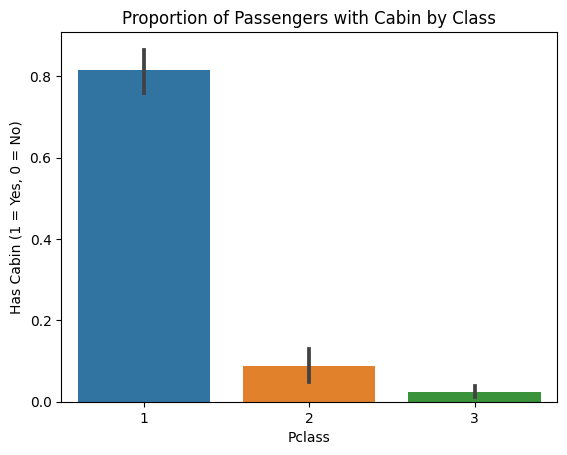

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x='Pclass', y='HasCabin', data=df)
plt.title("Proportion of Passengers with Cabin by Class")
plt.ylabel("Has Cabin (1 = Yes, 0 = No)")
plt.show()


In [11]:
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1  # +1 includes the passenger themself


In [12]:
test_df['FamilySize'] = test_df['SibSp'] + test_df['Parch'] + 1  # +1 includes the passenger themself


In [13]:
survival_by_family = df.groupby('FamilySize')['Survived'].mean()
print(survival_by_family)


FamilySize
1     0.303538
2     0.552795
3     0.578431
4     0.724138
5     0.200000
6     0.136364
7     0.333333
8     0.000000
11    0.000000
Name: Survived, dtype: float64


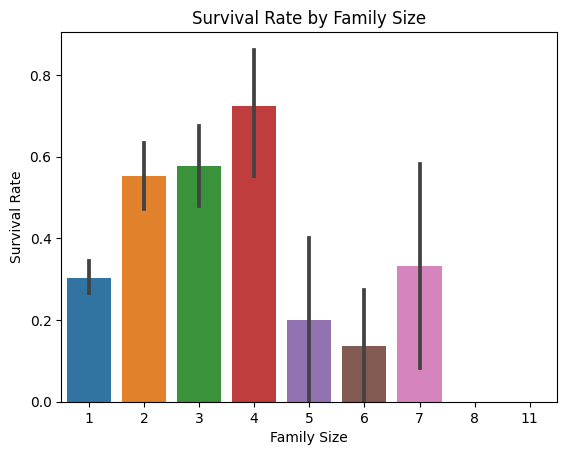

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x='FamilySize', y='Survived', data=df)
plt.title("Survival Rate by Family Size")
plt.ylabel("Survival Rate")
plt.xlabel("Family Size")
plt.show()


In [15]:
def family_group(size):
    if size == 1:
        return 'Solo'
    elif size <= 4:
        return 'Small'
    elif size <= 6:
        return 'Medium'
    else:
        return 'Large'

df['FamilyGroup'] = df['FamilySize'].apply(family_group)


In [16]:
def family_group(size):
    if size == 1:
        return 'Solo'
    elif size <= 4:
        return 'Small'
    elif size <= 6:
        return 'Medium'
    else:
        return 'Large'

test_df['FamilyGroup'] = test_df['FamilySize'].apply(family_group)


In [17]:
df.groupby('Pclass')['Fare'].mean()


Pclass
1    84.154687
2    20.662183
3    13.675550
Name: Fare, dtype: float64

Text(0.5, 1.0, 'Fare Distribution by Passenger Class')

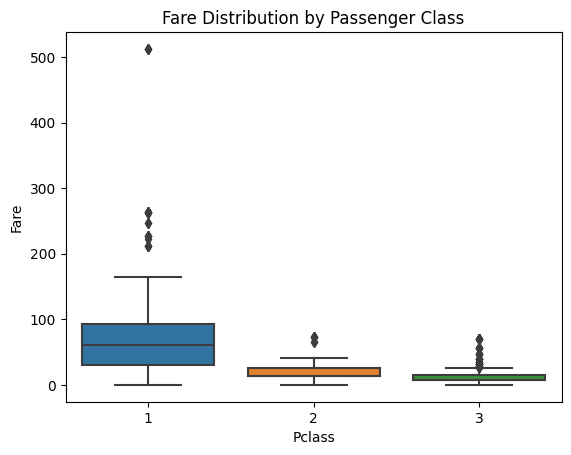

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='Pclass', y='Fare', data=df)
plt.title("Fare Distribution by Passenger Class")


In [19]:
df['Fare_log'] = df['Fare'].apply(lambda x: np.log1p(x))  # log1p handles 0 safely

In [20]:
test_df['Fare_log'] = test_df['Fare'].apply(lambda x: np.log1p(x))  # log1p handles 0 safely

In [21]:
import warnings
warnings.filterwarnings('ignore')

In [22]:
# 1. Impute missing Age using median by Sex and Pclass
df['Age'] = df.groupby(['Sex', 'Pclass'])['Age'].transform(lambda x: x.fillna(x.median()))

# 2. Impute missing Embarked values with mode
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

# 3. Extract Deck from Cabin and impute 'U' (Unknown) for missing cabins
df['Deck'] = df['Cabin'].str[0]
df['Deck'].fillna('U', inplace=True)

In [23]:
# 1. Impute missing Age using median by Sex and Pclass
test_df['Age'] = test_df.groupby(['Sex', 'Pclass'])['Age'].transform(lambda x: x.fillna(x.median()))

# 2. Impute missing Embarked values with mode
test_df['Embarked'].fillna(test_df['Embarked'].mode()[0], inplace=True)

# 3. Extract Deck from Cabin and impute 'U' (Unknown) for missing cabins
test_df['Deck'] = test_df['Cabin'].str[0]
test_df['Deck'].fillna('U', inplace=True)

In [24]:
print(df.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'HasCabin',
       'FamilySize', 'FamilyGroup', 'Fare_log', 'Deck'],
      dtype='object')


In [25]:
print(test_df.columns)

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'HasCabin', 'FamilySize',
       'FamilyGroup', 'Fare_log', 'Deck'],
      dtype='object')


In [26]:
df.isnull().sum().sort_values(ascending=False).head(15)

Cabin          687
PassengerId      0
Fare             0
Fare_log         0
FamilyGroup      0
FamilySize       0
HasCabin         0
Embarked         0
Ticket           0
Survived         0
Parch            0
SibSp            0
Age              0
Sex              0
Name             0
dtype: int64

In [27]:
test_df.isnull().sum().sort_values(ascending=False).head(15)

Cabin          327
Fare             1
Fare_log         1
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Embarked         0
HasCabin         0
FamilySize       0
FamilyGroup      0
dtype: int64

In [28]:
df.drop('Cabin', axis=1, inplace=True)


In [29]:
test_df.drop('Cabin', axis=1, inplace=True)


In [30]:
df.isnull().sum().sort_values(ascending=False).head(15)

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
HasCabin       0
FamilySize     0
FamilyGroup    0
Fare_log       0
dtype: int64

In [31]:
# Fill missing Fare based on median Fare within each Pclass
df['Fare'] = df.groupby('Pclass')['Fare'].transform(
    lambda x: x.fillna(x.median())
)
df['Fare_log'] = df['Fare'].apply(lambda x: np.log(x + 1))


In [32]:
# Fill missing Fare based on median Fare within each Pclass
test_df['Fare'] = test_df.groupby('Pclass')['Fare'].transform(
    lambda x: x.fillna(x.median())
)
test_df['Fare_log'] = test_df['Fare'].apply(lambda x: np.log(x + 1))


In [33]:
test_df.isnull().sum().sort_values(ascending=False).head(15)

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
HasCabin       0
FamilySize     0
FamilyGroup    0
Fare_log       0
Deck           0
dtype: int64

In [34]:
print(df.select_dtypes(include='object').columns)  # Should be empty
print(df.isnull().sum().sum()) 

Index(['Name', 'Sex', 'Ticket', 'Embarked', 'FamilyGroup', 'Deck'], dtype='object')
0


In [35]:
df.groupby('Embarked')['Survived'].mean()


Embarked
C    0.553571
Q    0.389610
S    0.339009
Name: Survived, dtype: float64

In [36]:
df.groupby('Sex')['Survived'].mean()


Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

In [37]:
# Group by Sex, Age (you might want to bin age first), and Survived
df['AgeBin'] = pd.cut(df['Age'], bins=[0, 12, 18, 35, 60, 80], labels=['Child', 'Teen', 'YoungAdult', 'Adult', 'Senior'])

grouped = df.groupby(['Sex', 'AgeBin', 'Survived'])['PassengerId'].count().reset_index()
grouped.rename(columns={'PassengerId': 'Count'}, inplace=True)
print(grouped)


       Sex      AgeBin  Survived  Count
0   female       Child         0     13
1   female       Child         1     19
2   female        Teen         0      9
3   female        Teen         1     27
4   female  YoungAdult         0     43
5   female  YoungAdult         1    130
6   female       Adult         0     16
7   female       Adult         1     54
8   female      Senior         0      0
9   female      Senior         1      3
10    male       Child         0     16
11    male       Child         1     21
12    male        Teen         0     31
13    male        Teen         1      3
14    male  YoungAdult         0    287
15    male  YoungAdult         1     54
16    male       Adult         0    117
17    male       Adult         1     29
18    male      Senior         0     17
19    male      Senior         1      2


In [38]:
# Group by Sex, Age (you might want to bin age first), and Survived
test_df['AgeBin'] = pd.cut(test_df['Age'], bins=[0, 12, 18, 35, 60, 80], labels=['Child', 'Teen', 'YoungAdult', 'Adult', 'Senior'])

#grouped = df.groupby(['Sex', 'AgeBin', 'Survived'])['PassengerId'].count().reset_index()
#grouped.rename(columns={'PassengerId': 'Count'}, inplace=True)
#print(grouped)


In [39]:
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
df['Title'] = df['Title'].replace({
    'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs',
    'Lady': 'Rare', 'Countess': 'Rare', 'Capt': 'Rare',
    'Col': 'Rare', 'Don': 'Rare', 'Dr': 'Rare', 'Major': 'Rare',
    'Rev': 'Rare', 'Sir': 'Rare', 'Jonkheer': 'Rare', 'Dona': 'Rare'
})


In [40]:
test_df['Title'] = test_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
test_df['Title'] = test_df['Title'].replace({
    'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs',
    'Lady': 'Rare', 'Countess': 'Rare', 'Capt': 'Rare',
    'Col': 'Rare', 'Don': 'Rare', 'Dr': 'Rare', 'Major': 'Rare',
    'Rev': 'Rare', 'Sir': 'Rare', 'Jonkheer': 'Rare', 'Dona': 'Rare'
})


In [41]:
df['Sex*Pclass'] = df['Sex'].map({'male': 0, 'female': 1}) * df['Pclass']


In [42]:
test_df['Sex*Pclass'] = test_df['Sex'].map({'male': 0, 'female': 1}) * test_df['Pclass']


In [43]:
df['Fare_Per_Person'] = df['Fare'] / df['FamilySize']
df['Fare_Per_Person'].fillna(df['Fare_Per_Person'].median(), inplace=True)


In [44]:
test_df['Fare_Per_Person'] = test_df['Fare'] / test_df['FamilySize']
test_df['Fare_Per_Person'].fillna(test_df['Fare_Per_Person'].median(), inplace=True)


In [45]:
survival_rate = df.groupby(['Sex', 'AgeBin'])['Survived'].mean().reset_index()
print(survival_rate)


      Sex      AgeBin  Survived
0  female       Child  0.593750
1  female        Teen  0.750000
2  female  YoungAdult  0.751445
3  female       Adult  0.771429
4  female      Senior  1.000000
5    male       Child  0.567568
6    male        Teen  0.088235
7    male  YoungAdult  0.158358
8    male       Adult  0.198630
9    male      Senior  0.105263


In [46]:
df.isnull().sum().sort_values(ascending=False).head(15)

PassengerId    0
Survived       0
Sex*Pclass     0
Title          0
AgeBin         0
Deck           0
Fare_log       0
FamilyGroup    0
FamilySize     0
HasCabin       0
Embarked       0
Fare           0
Ticket         0
Parch          0
SibSp          0
dtype: int64

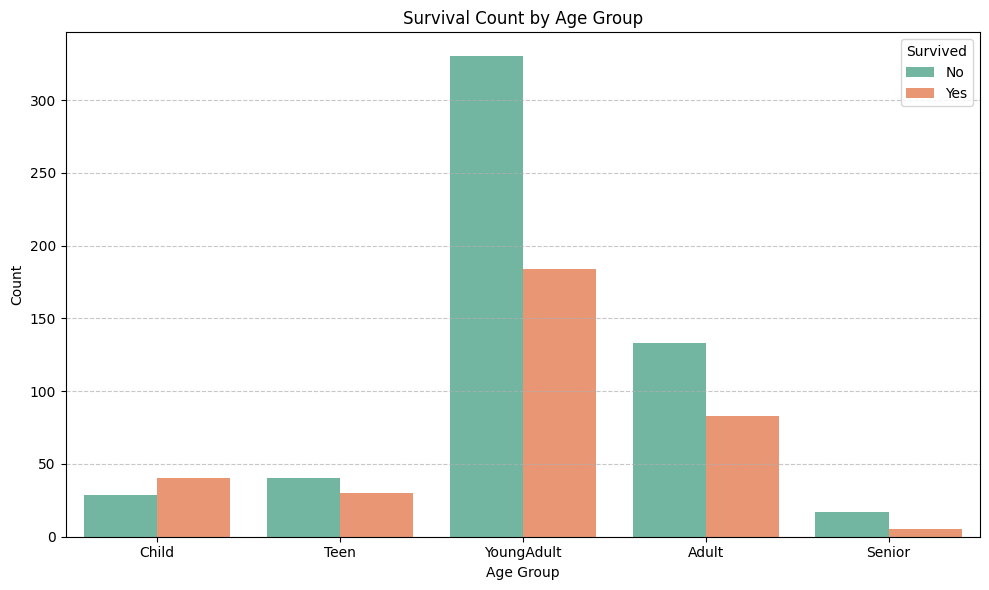

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

# First, bin ages for grouping
df['AgeBin'] = pd.cut(df['Age'], bins=[0, 12, 18, 35, 60, 80], labels=['Child', 'Teen', 'YoungAdult', 'Adult', 'Senior'])

# Create a countplot of survival by gender and age group
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='AgeBin', hue='Survived', palette='Set2', dodge=True)
plt.title('Survival Count by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.legend(title='Survived', labels=['No', 'Yes'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


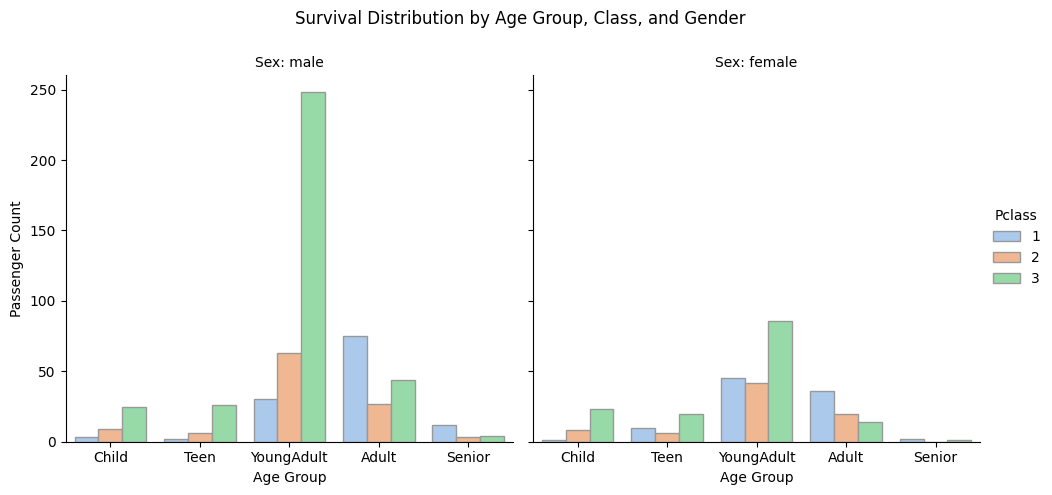

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# Make sure AgeBin exists
df['AgeBin'] = pd.cut(df['Age'], bins=[0, 12, 18, 35, 60, 80], 
                      labels=['Child', 'Teen', 'YoungAdult', 'Adult', 'Senior'])

# Set up the grid
g = sns.catplot(
    data=df, kind="count", 
    x="AgeBin", hue="Pclass", col="Sex",
    palette="pastel", edgecolor=".6"
)

g.set_titles("Sex: {col_name}")
g.set_axis_labels("Age Group", "Passenger Count")
g._legend.set_title("Pclass")
plt.subplots_adjust(top=0.85)
g.fig.suptitle("Survival Distribution by Age Group, Class, and Gender")
plt.show()


In [49]:
print("✅ Object columns now:", df.select_dtypes(include='object').columns.tolist())


✅ Object columns now: ['Name', 'Sex', 'Ticket', 'Embarked', 'FamilyGroup', 'Deck', 'Title']


In [50]:
print("✅ Object columns now:", test_df.select_dtypes(include='object').columns.tolist())


✅ Object columns now: ['Name', 'Sex', 'Ticket', 'Embarked', 'FamilyGroup', 'Deck', 'Title']


In [51]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

#  Encode 'Sex' using LabelEncoder
df['Sex'] = LabelEncoder().fit_transform(df['Sex'].astype(str))  # male=1, female=0

#  Drop 'Ticket'
df.drop(columns=['Ticket'], inplace=True)

#  One-hot encode remaining object columns
categorical_cols = ['Embarked', 'FamilyGroup', 'Deck', 'Title']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# ✅ Final check
print("✅ Object columns now:", df.select_dtypes(include='object').columns.tolist())


✅ Object columns now: ['Name']


In [52]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

#  Encode 'Sex' using LabelEncoder
test_df['Sex'] = LabelEncoder().fit_transform(test_df['Sex'].astype(str))  # male=1, female=0

#  Drop 'Ticket'
test_df.drop(columns=['Ticket'], inplace=True)

#  One-hot encode remaining object columns
categorical_cols = ['Embarked', 'FamilyGroup', 'Deck', 'Title']
test_df = pd.get_dummies(test_df, columns=categorical_cols, drop_first=True)

# ✅ Final check
print("✅ Object columns now:", test_df.select_dtypes(include='object').columns.tolist())


✅ Object columns now: ['Name']


In [53]:
df.drop('Name', axis=1, inplace=True)
print("✅ Object columns now:", df.select_dtypes(include='object').columns.tolist())

✅ Object columns now: []


In [54]:
test_df.drop('Name', axis=1, inplace=True)
print("✅ Object columns now:", test_df.select_dtypes(include='object').columns.tolist())

✅ Object columns now: []


In [55]:
if df.select_dtypes(include='object').shape[1] > 0:
    print("❌ Still has object columns:", df.select_dtypes(include='object').columns.tolist())
    raise ValueError("You must encode or drop all object columns before modeling.")
else:
    print("✅ All features are numeric and ready for model training.")


✅ All features are numeric and ready for model training.


In [56]:
if test_df.select_dtypes(include='object').shape[1] > 0:
    print("❌ Still has object columns:", test_df.select_dtypes(include='object').columns.tolist())
    raise ValueError("You must encode or drop all object columns before modeling.")
else:
    print("✅ All features are numeric and ready for model training.")


✅ All features are numeric and ready for model training.


## Model Benchmarking

- Random Forest
- ElasticNet
- XGBoost

In [57]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, f1_score
import numpy as np
import pandas as pd

# Step 1: Define Features and Target
#X = df.drop(columns=['PassengerId', 'Survived'])  # Ensure df is cleaned and encoded
#y = df['Survived']
# Drop PassengerId and target column
X = df.drop(columns=['PassengerId', 'Survived'])

# Convert all boolean columns to integers
bool_cols = X.select_dtypes(include='bool').columns
X[bool_cols] = X[bool_cols].astype(int)

# Convert categorical column 'AgeBin' to string, then one-hot encode
if 'AgeBin' in X.columns:
    X['AgeBin'] = X['AgeBin'].astype(str)

# One-hot encode any object or category type columns
X = pd.get_dummies(X, drop_first=True)

# Force everything to float32
X = X.apply(pd.to_numeric, errors='coerce').fillna(0).astype('float32')

# Target
y = df['Survived']


# Step 2: Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Step 3: No scaling needed for Random Forest

# Step 4: Define Model and Hyperparameter Grid
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']  # Removed 'auto'
}

base_model = RandomForestClassifier(random_state=42)

# Step 5: Randomized Search
rf_search = RandomizedSearchCV(
    base_model,
    param_distributions=param_grid,
    n_iter=20,
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

rf_search.fit(X_train, y_train)

# Step 6: Evaluation
y_pred = rf_search.predict(X_val)

print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))
print("Accuracy:", accuracy_score(y_val, y_pred))
print("ROC AUC Score:", roc_auc_score(y_val, y_pred))
print("F1 Score:", f1_score(y_val, y_pred))


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Confusion Matrix:
 [[97 13]
 [22 47]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.88      0.85       110
           1       0.78      0.68      0.73        69

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179

Accuracy: 0.8044692737430168
ROC AUC Score: 0.7814888010540184
F1 Score: 0.7286821705426356


In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, f1_score

# Step 1: Feature Scaling (needed for ElasticNet)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Step 2: Define hyperparameter grid
param_grid = {
    'C': np.logspace(-3, 2, 50),      # Inverse regularization strength
    'l1_ratio': np.linspace(0, 1, 10) # 0 = Ridge, 1 = Lasso
}

# Step 3: Set up Logistic Regression with Elastic Net
elastic_net = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    max_iter=5000,
    random_state=42
)

search_en = RandomizedSearchCV(
    elastic_net,
    param_distributions=param_grid,
    n_iter=20,
    cv=5,
    random_state=42,
    verbose=1,
    n_jobs=-1
)

# Step 4: Fit model
search_en.fit(X_train_scaled, y_train)

# Step 5: Evaluate
y_pred_en = search_en.predict(X_val_scaled)

print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_en))
print("Classification Report:\n", classification_report(y_val, y_pred_en))
print("Accuracy:", accuracy_score(y_val, y_pred_en))
print("ROC AUC Score:", roc_auc_score(y_val, y_pred_en))
print("F1 Score:", f1_score(y_val, y_pred_en))


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Confusion Matrix:
 [[98 12]
 [19 50]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.89      0.86       110
           1       0.81      0.72      0.76        69

    accuracy                           0.83       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.83      0.83      0.82       179

Accuracy: 0.8268156424581006
ROC AUC Score: 0.8077733860342556
F1 Score: 0.7633587786259542


In [59]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, f1_score

# Step 1: Define Model and Param Grid
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=20,
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Step 2: Fit model (X_train, y_train are already defined)
xgb_search.fit(X_train, y_train)

# Step 3: Evaluation
y_pred_xgb = xgb_search.predict(X_val)

print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_xgb))
print("Classification Report:\n", classification_report(y_val, y_pred_xgb))
print("Accuracy:", accuracy_score(y_val, y_pred_xgb))
print("ROC AUC Score:", roc_auc_score(y_val, y_pred_xgb))
print("F1 Score:", f1_score(y_val, y_pred_xgb))


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Confusion Matrix:
 [[96 14]
 [22 47]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.87      0.84       110
           1       0.77      0.68      0.72        69

    accuracy                           0.80       179
   macro avg       0.79      0.78      0.78       179
weighted avg       0.80      0.80      0.80       179

Accuracy: 0.7988826815642458
ROC AUC Score: 0.7769433465085639
F1 Score: 0.7230769230769231


In [60]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import joblib  # optional if you saved the model

# Step 1: Prepare test_df the same way as train_df
X_test = test_df.copy()

# Convert AgeBin to string, then one-hot encode
if 'AgeBin' in X_test.columns:
    X_test['AgeBin'] = X_test['AgeBin'].astype(str)

# Convert bools to int
bool_cols = X_test.select_dtypes(include='bool').columns
X_test[bool_cols] = X_test[bool_cols].astype(int)

# One-hot encode object/category columns
X_test = pd.get_dummies(X_test, drop_first=True)

# Match test_df columns to training set
missing_cols = set(X_train.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0  # Add missing columns with 0
X_test = X_test[X_train.columns]  # Reorder columns

# Scale using the same scaler used on X_train
X_test_scaled = scaler.transform(X_test)

# Step 2: Predict using the trained Elastic Net model
y_test_preds = search_en.predict(X_test_scaled)  # or rf_search.predict(...) for RF

# Step 3: Create submission DataFrame
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': y_test_preds
})

# Step 4: Save to CSV
submission.to_csv('submission.csv', index=False)
print("✅ submission.csv generated successfully.")


✅ submission.csv generated successfully.
